In [1]:
# 환경 설정
from dotenv import load_dotenv
import os
import pandas as pd
from ai_agent_v2 import DataAnayticsAssistant

# OpenAI API 키 로드
load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY')

PROCESSED_DATA_PATH = "../output/stage1/processed_data_info.xlsx"
mart_name = "cust_intg"
def load_processed_data_info():
    """사전에 분석된 데이터 정보 로드"""
    if not os.path.exists(PROCESSED_DATA_PATH):
        return None
    else:
        # 모든 시트 로드
        return pd.read_excel(PROCESSED_DATA_PATH, sheet_name=mart_name)


# ✅ Streamlit 실행 시 데이터 로드
mart_info = load_processed_data_info()

# 어시스턴트 초기화
assistant = DataAnayticsAssistant(openai_api_key, mart_info)

df = pd.read_pickle(f'../data/{mart_name}.pkl')

# 데이터프레임 설정
assistant.set_active_mart(df, mart_name)


✅ 그래프 컴파일 완료
✅ 1개의 데이터프레임이 성공적으로 설정되었습니다.
📊 데이터마트 이름: cust_intg
🔹 데이터 크기: 120000행 x 123열




새질문===============================================================================================


🔄 새로운 요청 처리 시작: 'CMIP컬럼에 대해서 Shapiro-Wilk 검정을 수행하여 변수의 정규성을 검정하고, p-value 결과를 출력하는 코드를 작성해 주세요.'

👨‍💼 Supervisor 단계:
🏃🏿‍➡️ 다음 단계: Analytics

📊 [handle_analytics] 분석 요청 처리 시작

🤖 코드 생성 단계:
✨ 생성된 코드:
```python
from scipy.stats import shapiro

# Shapiro-Wilk test for normality on 'CMIP' column
stat, p_value = shapiro(df['변액종신CMIP'].dropna())

# Store the result in a DataFrame
result_df = pd.DataFrame({'Statistic': [stat], 'p-value': [p_value]})
```


🔄 샘플 실행 단계
📊 cust_intg: 50개 샘플 추출
❌ 샘플 코드 실행 실패
에러 타입: NameError
에러 메시지: name 'pd' is not defined
에러 발생 위치:
Traceback (most recent call last):
  File "c:\Users\권상우\GENBA-main\genba\src\ai_agent_v2.py", line 290, in execute_sample_code
    exec(code_to_execute, exec_globals)
  File "<string>", line 7, in <module>
NameError: name 'pd' is not defined


🔄 샘플 실행 후 경로 결정
🔄 [route_after_sample] error_message: True
🔄 [route_after_sample] error_messag

c:\Users\권상우\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 120000.
  res = hypotest_fun_out(*samples, **kwds)


,Statistic,p-value
0,0.814916,4.085976e-134


🔄 result is int, float : False

📂 처리 데이터 저장 단계
📂 처리된 데이터 저장 경로: ../output/data_20250219175856.pkl

🔄 인사이트 도출 단계:
🌀 생성된 인사이트:
1. 주요 발견사항
   - Shapiro-Wilk 검정 결과, CMIP 컬럼의 p-value가 0.0으로 나타났습니다. 이는 CMIP 데이터가 정규 분포를 따르지 않는다는 것을 강하게 시사합니다. 일반적으로 p-value가 0.05보다 작으면 정규성을 기각할 수 있습니다.

2. 특이점
   - p-value가 0.0으로 매우 낮게 나타난 것은 데이터가 정규 분포에서 크게 벗어나 있다는 것을 의미합니다. 이는 데이터의 분포가 비대칭적이거나 극단적인 값(outliers)이 존재할 가능성을 암시합니다.

3. 추천 사항
   - CMIP 컬럼의 데이터가 정규 분포를 따르지 않으므로, 정규성을 가정하는 통계 분석 방법을 사용할 때 주의가 필요합니다.
   - 데이터의 분포를 시각화하여 비정규성의 원인을 파악하는 것이 좋습니다. 예를 들어, 히스토그램이나 Q-Q 플롯을 통해 데이터의 분포를 확인할 수 있습니다.
   - 비정규성을 해결하기 위해 데이터 변환(예: 로그 변환, 제곱근 변환 등)을 고려할 수 있습니다.
   - 정규성을 가정하지 않는 비모수적 방법을 사용하여 분석을 진행하는 것도 하나의 방법입니다.
🌀 차트 필요 여부: yes

🔄 인사이트 라우팅 단계
📊 차트 생성 단계로 진행합니다

📊 차트 생성 단계
📊 실행할 차트 코드:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Data
statistic = 0.81
p_value = 0.0

# Create a Q-Q plot
plt.figure(figsize=(8, 6))
stats.probplot(np.random.normal(loc=0, scale=1, size=1000), dist

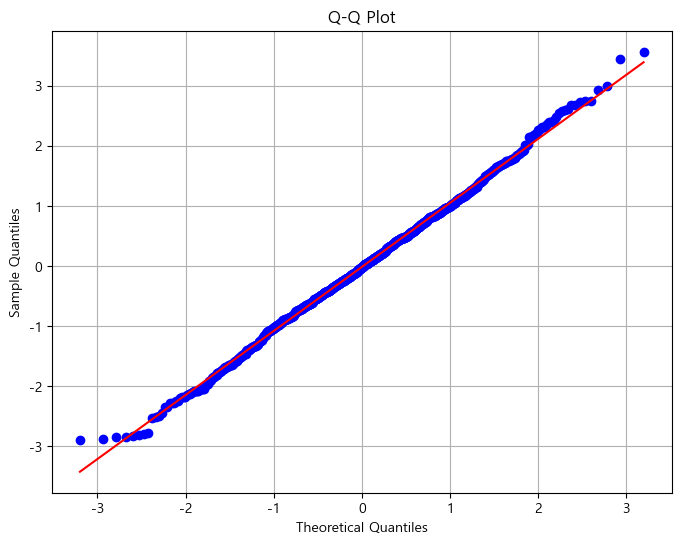

📈 차트 생성 성공: ../img/chart_20250219175904.png

📑 보고서 생성 단계
✅ 보고서 생성 완료
1. 요약
   - CMIP 컬럼에 대한 Shapiro-Wilk 검정 결과, p-value가 0.0으로 나타나 CMIP 데이터가 정규 분포를 따르지 않는다는 결론을 얻었습니다. 이는 데이터 분석 시 정규성을 가정하는 방법을 사용할 수 없음을 의미합니다.

2. 분석 방법
   - Shapiro-Wilk 검정을 통해 CMIP 컬럼의 정규성을 검정하였습니다. 이 검정은 데이터가 정규 분포를 따르는지를 확인하는 통계적 방법으로, p-value가 0.05보다 작으면 정규성을 기각할 수 있습니다.

3. 주요 발견사항
   - CMIP 컬럼의 p-value가 0.0으로 매우 낮게 나타났습니다. 이는 데이터가 정규 분포에서 크게 벗어나 있다는 것을 강하게 시사합니다.
   - 데이터의 비정규성은 비대칭적 분포나 극단적인 값의 존재 가능성을 암시합니다.

4. 결론 및 제언
   - CMIP 데이터의 정규성을 가정하는 통계 분석 방법을 사용할 때 주의가 필요합니다.
   - 데이터의 분포를 시각화하여 비정규성의 원인을 파악하는 것이 중요합니다. 히스토그램이나 Q-Q 플롯을 통해 데이터의 분포를 확인할 수 있습니다.
   - 비정규성을 해결하기 위해 데이터 변환(예: 로그 변환, 제곱근 변환 등)을 고려할 수 있습니다.
   - 정규성을 가정하지 않는 비모수적 방법을 사용하여 분석을 진행하는 것도 하나의 방법입니다.


In [2]:
result = assistant.ask(f"""CMIP컬럼에 대해서 Shapiro-Wilk 검정을 수행하여 변수의 정규성을 검정하고, p-value 결과를 출력하는 코드를 작성해 주세요.""")

In [ ]:
df_mart = pd.read_pickle(f'../data/cust_enroll_history.pkl')

# 데이터프레임 가정 (df_mart)
df_mart['기준년월'] = df_mart['가입년월일'].astype(str).str[:7].str.replace('-', '')

# 고객ID, 기준년월별 가입담보 여부 피벗 테이블 생성
df_pivot = df_mart.pivot_table(index=['고객ID', '기준년월'], 
                             columns='가입담보명', 
                             values='가입담보금액', 
                             aggfunc='count', 
                             fill_value=0)

# 컬럼명에서 가입담보명 인덱스 제거
df_pivot.columns.name = None

# 가입 여부를 Y/N으로 변환하고 컬럼명 변경
df_pivot = df_pivot.applymap(lambda x: 'Y' if x > 0 else 'N')
df_pivot.columns = [f'Y_{col}' for col in df_pivot.columns]
df_pivot = df_pivot.reset_index()

df_pivot['기준년월'] = df_pivot['기준년월'].astype(str).str.replace('-', '')
df['기준년월'] = df['기준년월'].astype(str).str.replace('-', '')

# 결과 확인
# df_pivot.drop(columns=['가입담보명'], inplace=True)

df_merged = pd.merge(df, df_pivot, on=['고객ID', '기준년월'], how='left')
df_merged[[x for x in df_merged.columns if 'Y_' in x]] = df_merged[[x for x in df_merged.columns if 'Y_' in x]].fillna('N')
df_merged[:100].to_csv('df_merged.csv', index=False)

In [ ]:
import pandas as pd
import os
from openpyxl import Workbook
from openpyxl.drawing.image import Image
from openpyxl.utils.dataframe import dataframe_to_rows
import time
from uuid import uuid4

data = [
    ("데이터 준비"       , "데이터에서 결측치가 많은 컬럼을 찾아내고, 일정 비율 이상 결측치가 포함된 컬럼을 제거해주세요."),
]
df_questions = pd.DataFrame(data, columns=["분류", "질문"])

import time


# 결과 리스트 초기화
results = []

# 엑셀 파일 저장 경로
excel_filename = f"../output/stage1/analysis_results_xlsx_{uuid4()}.xlsx"

# 반복문으로 결과 저장
for index, row in df_questions.iterrows():
    question = row["질문"]
    print(f"🔍 | 처리 중: {question} | 순서 = {index} / {len(df_questions)}")

    start_time = time.time()
    timeout_flag = False

    try:
        # AI Assistant 실행
        result = assistant.ask(question)

        elapsed_time = time.time() - start_time
        if elapsed_time > 300:
            timeout_flag = True
            result = {"error_message": "Timeout occurred. Execution took too long."}

    except Exception as e:
        print(f"⚠️ 오류 발생: {e}")
        result = {"error_message": str(e)}   

    # 차트 이미지 경로가 존재하면 실제 파일명을 유지
    chart_display = result.get('chart_filename', 'N/A') if result.get('chart_filename') not in [None, 'N/A'] else "N/A"

    # 결과 정리
    values = [
        result.get('messages')[0].content if result.get('messages') and len(result['messages']) > 0 else 'N/A',
        result.get('validated_code', 'N/A'),
        result.get('insights', 'N/A'),
        result.get('chart_needed', 'N/A'),
        result.get('chart_filename', 'N/A'),
        chart_display,  # ✅ 실제 이미지 경로 저장
        result.get('report_filename', 'N/A'),
        result.get('data_id', 'N/A'),
        "Timeout" if timeout_flag else "Completed"
    ]
    
    results.append(values)

# 데이터프레임 생성
df_results = pd.DataFrame(results, columns=[
    '메시지', '검증된 코드', '인사이트', '차트 필요 여부', '차트 파일명', '차트 이미지', '리포트', '데이터 ID', '상태'
])

# 엑셀 파일 생성 및 데이터 저장
wb = Workbook()
ws = wb.active
ws.title = "분석 결과"

# 데이터프레임을 엑셀로 변환
for r in dataframe_to_rows(df_results, index=False, header=True):
    ws.append(r)

# ✅ 엑셀 셀 크기 조정 (F열: 차트 이미지)
ws.column_dimensions["F"].width = 30  # F열 너비 설정
for i in range(2, len(df_results) + 2):
    ws.row_dimensions[i].height = 100  # 각 행 높이 설정

# ✅ 차트 이미지 삽입 및 크기 조정
for idx, row in df_results.iterrows():
    chart_path = row["차트 파일명"]
    if os.path.exists(chart_path) :
        img = Image(chart_path)

        # 🔹 이미지 크기 조정 (셀 크기에 맞춤)
        img.width = 200  # 가로 크기 (픽셀)
        img.height = 100  # 세로 크기 (픽셀)

        # 🔹 엑셀 셀 위치 설정 (F열)
        ws.add_image(img, f"F{idx+2}")

# 엑셀 파일 저장
wb.save(excel_filename)

print(f"📊 분석 결과가 {excel_filename}에 저장되었습니다.")


In [6]:
import pandas as pd
import os
from openpyxl import Workbook
from openpyxl.drawing.image import Image
from openpyxl.utils.dataframe import dataframe_to_rows
import time
from datetime import datetime
from uuid import uuid4

data = [
    ("데이터 준비"       , "데이터에서 결측치가 많은 컬럼을 찾아내고, 일정 비율 이상 결측치가 포함된 컬럼을 제거해주세요."),
]
df_questions = pd.DataFrame(data, columns=["분류", "질문"])

import time


# 결과 리스트 초기화
results = []

# 엑셀 파일 저장 경로
excel_filename = f"../output/stage1/analysis_results_xlsx_{datetime.now().strftime('%Y%m%d_%H%M%S')}.xlsx"

# 반복문으로 결과 저장
for index, row in df_questions.iterrows():
    question = row["질문"]
    print(f"🔍 | 처리 중: {question} | 순서 = {index} / {len(df_questions)}")

    start_time = time.time()
    timeout_flag = False

    try:
        # AI Assistant 실행
        result = assistant.ask(question)

        elapsed_time = time.time() - start_time
        if elapsed_time > 300:
            timeout_flag = True
            result = {"error_message": "Timeout occurred. Execution took too long."}

    except Exception as e:
        print(f"⚠️ 오류 발생: {e}")
        result = {"error_message": str(e)}   

    # 차트 이미지 경로가 존재하면 실제 파일명을 유지
    chart_display = result.get('chart_filename', 'N/A') if result.get('chart_filename') not in [None, 'N/A'] else "N/A"

    # 결과 정리
    values = [
        result.get('messages')[0].content if result.get('messages') and len(result['messages']) > 0 else 'N/A',
        result.get('validated_code', 'N/A'),
        result.get('insights', 'N/A'),
        result.get('chart_needed', 'N/A'),
        result.get('chart_filename', 'N/A'),
        chart_display,  # ✅ 실제 이미지 경로 저장
        result.get('report_filename', 'N/A'),
        result.get('data_id', 'N/A'),
        "Timeout" if timeout_flag else "Completed",
        result.get('analysis_result', 'N/A'),
    ]
    
    results.append(values)
    print(f'analysis result : {results}')

# 데이터프레임 생성
df_results = pd.DataFrame(results, columns=[
    '메시지', '검증된 코드', '인사이트', '차트 필요 여부', '차트 파일명', '차트 이미지', '리포트', '데이터 ID', '상태', '분석 결과'
])

# 엑셀 파일 생성 및 데이터 저장
wb = Workbook()
ws = wb.active
ws.title = "분석 결과"

# 데이터프레임을 엑셀로 변환
for r in dataframe_to_rows(df_results, index=False, header=True):
    ws.append(r)

# ✅ 엑셀 셀 크기 조정 (F열: 차트 이미지)
ws.column_dimensions["F"].width = 30  # F열 너비 설정
for i in range(2, len(df_results) + 2):
    ws.row_dimensions[i].height = 100  # 각 행 높이 설정

# ✅ 차트 이미지 삽입 및 크기 조정
for idx, row in df_results.iterrows():
    chart_path = row["차트 파일명"]
    if os.path.exists(chart_path) :
        img = Image(chart_path)

        # 🔹 이미지 크기 조정 (셀 크기에 맞춤)
        img.width = 200  # 가로 크기 (픽셀)
        img.height = 100  # 세로 크기 (픽셀)

        # 🔹 엑셀 셀 위치 설정 (F열)
        ws.add_image(img, f"F{idx+2}")

# 엑셀 파일 저장
wb.save(excel_filename)

print(f"📊 분석 결과가 {excel_filename}에 저장되었습니다.")


🔍 | 처리 중: 데이터에서 결측치가 많은 컬럼을 찾아내고, 일정 비율 이상 결측치가 포함된 컬럼을 제거해주세요. | 순서 = 0 / 1




🔄 새로운 요청 처리 시작: '데이터에서 결측치가 많은 컬럼을 찾아내고, 일정 비율 이상 결측치가 포함된 컬럼을 제거해주세요.'

👨‍💼 Supervisor 단계:
🏃🏿‍➡️ 다음 단계: Analytics

📊 [handle_analytics] 분석 요청 처리 시작

🤖 코드 생성 단계:
✨ 생성된 코드:
```python
threshold = 0.5
missing_ratio = df.isnull().mean()
columns_to_drop = missing_ratio[missing_ratio > threshold].index
result_df = df.drop(columns=columns_to_drop)
```


🔄 샘플 실행 단계
📊 cust_intg: 50개 샘플 추출
✅ 샘플 코드 실행 성공
✅ 코드 검증 완료, 전체 데이터 실행으로 진행합니다

📊 전체 데이터 실행 단계:
🔹 전체 데이터 실행 환경에 추가된 데이터프레임 목록: ['df', 'cust_intg']
🔄 전체 데이터 실행 결과


,고객ID,나이,성별,수익자여부,두낫콜여부,운전코드명,성별코드,피보험자여부,보험연령,직업분류명,...,변액보유여부,변액최대납입회차,변액유지계약수,변액기납입보험료,변액종신CMIP,변액종신보유여부,변액종신최대납입회차,변액종신유지계약수,변액종신기납입보험료,기준년월
0,25226,60대,여성,1,1.0,승용차(자가용),02,1,66,주부 및 비경제활동 인구,...,0,11.09,0.0,6424.05,69074.36,0,3.15,0.0,539090.38,202405
1,95256,40대,남성,1,0.0,화물차(자가용),02,1,42,[OLD] 주부 및 학생 비경제활동,...,0,3.98,0.0,9592.97,2023.21,0,34.68,0.0,3338509.65,202405
2,14751,40대,여성,1,1.0,NaN,02,1,49,NaN,...,0,4.06,0.0,22093.94,11006.27,0,9.01,0.0,1356509.39,202405
3,4478,50대,여성,1,0.0,운전안함,01,1,58,[OLD] 주부 및 학생 비경제활동,...,0,8.71,0.0,6071.17,6473.26,0,1.02,0.0,16478801.52,202405
4,100000,50대,여성,0,NaN,운전안함,02,1,52,판매종사자,...,0,1.94,0.0,16569.67,2852.47,0,17.67,0.0,373537.44,202405



📂 처리 데이터 저장 단계
📂 처리된 데이터 저장 경로: ../output/data_20250219130618.pkl

🔄 인사이트 도출 단계:
⚠️ 오류 발생: 'str' object has no attribute 'round'
📊 분석 결과가 ../output/stage1/analysis_results_xlsx_3c967c0a-a89e-4494-9e36-2240e0341a56.xlsx에 저장되었습니다.


In [ ]:
# 질문 목록을 데이터프레임으로 변환
data = [
    ("기본 데이터 처리", "데이터에서 결측치가 있는 컬럼을 제거하고, 남은 컬럼 목록을 출력해 주세요."),
    ("기본 데이터 처리", "모든 연속형 변수의 평균과 표준편차를 계산해 주세요."),
    ("기본 데이터 처리", "각 범주형 변수의 고유값 개수를 계산해 주세요."),
    ("기본 데이터 처리", "데이터에서 중복된 행을 제거한 후, 데이터 크기를 출력해 주세요."),
    ("기본 데이터 처리", "특정 컬럼(예: CB신용평점)의 이상치를 탐지하고 제거한 후 데이터 크기를 출력해 주세요."),
    ("기본 데이터 처리", "특정 컬럼(예: 나이)을 기준으로 데이터프레임을 정렬한 후, 상위 10개 데이터를 출력해 주세요."),
    ("기본 데이터 처리", "데이터의 모든 숫자형 컬럼을 정규화(Min-Max Scaling)하고, 변환된 데이터프레임을 출력해 주세요."),
    ("기본 데이터 처리", "고객ID별로 데이터를 그룹화하고, 각 그룹의 평균을 계산해 주세요."),
    ("기본 데이터 처리", "CB신용평점을 기준으로 5개 구간으로 나누고, 각 구간별 고객 수를 출력해 주세요."),
    ("기본 데이터 처리", "특정 날짜 컬럼(예: 기준년월)을 기준으로 데이터를 월별 집계하여 출력해 주세요."),
    ("EDA(탐색적 데이터 분석)", "데이터의 전체적인 통계 요약을 제공해 주세요."),
    ("EDA(탐색적 데이터 분석)", "데이터의 컬럼별 결측치 비율을 계산하고 시각화해 주세요."),
    ("EDA(탐색적 데이터 분석)", "수익자 여부에 따라 CB신용평점의 평균과 표준편차를 비교해 주세요."),
    ("EDA(탐색적 데이터 분석)", "데이터에서 이상치를 탐지하고, 이상치가 포함된 데이터를 출력해 주세요."),
    ("EDA(탐색적 데이터 분석)", "성별에 따른 신용등급 분포를 분석해 주세요."),
    ("EDA(탐색적 데이터 분석)", "운전코드명과 CB신용등급 간의 관계를 분석해 주세요."),
    ("EDA(탐색적 데이터 분석)", "두낫콜 여부에 따른 평균 나이를 비교해 주세요."),
    ("EDA(탐색적 데이터 분석)", "피보험자 여부에 따른 연속형 변수들의 분포 차이를 분석해 주세요."),
    ("EDA(탐색적 데이터 분석)", "데이터에서 가장 많이 등장하는 상위 5개 고객ID를 출력해 주세요."),
    ("EDA(탐색적 데이터 분석)", "고객ID별로 CB신용평점의 변화 추이를 시각화해 주세요."),
    ("머신러닝/패턴 분석", "CB신용평점을 예측하는 간단한 선형 회귀 모델을 학습해 주세요."),
    ("머신러닝/패턴 분석", "고객의 수익자여부를 예측하는 로지스틱 회귀 모델을 학습해 주세요."),
    ("머신러닝/패턴 분석", "주요 연속형 변수들의 다중공선성을 분석하고 VIF 값을 출력해 주세요."),
    ("머신러닝/패턴 분석", "고객 세그먼트를 찾기 위해 K-means 군집화를 수행해 주세요."),
    ("머신러닝/패턴 분석", "랜덤포레스트를 사용하여 CB신용등급을 예측하는 모델을 만들어 주세요."),
    ("머신러닝/패턴 분석", "PCA를 이용하여 데이터 차원을 축소한 후 주요 성분을 출력해 주세요."),
    ("머신러닝/패턴 분석", "성별을 예측하는 분류 모델을 학습하고 정확도를 평가해 주세요."),
    ("머신러닝/패턴 분석", "CB신용평점을 기준으로 고객을 고위험/저위험으로 분류하고, 그 비율을 출력해 주세요."),
    ("머신러닝/패턴 분석", "주요 변수를 선택하여 랜덤포레스트 기반 특징 중요도를 계산해 주세요."),
    ("머신러닝/패턴 분석", "KNN을 이용하여 고객 간 유사도를 분석해 주세요."),
    ("비즈니스 인사이트 도출", "연령대별 신용등급의 평균을 분석해 주세요."),
    ("비즈니스 인사이트 도출", "고객의 CB신용평점이 높은 그룹과 낮은 그룹 간의 주요 차이점을 분석해 주세요."),
    ("비즈니스 인사이트 도출", "특정 고객층(예: 두낫콜여부가 Yes인 고객)의 특성을 분석해 주세요."),
    ("비즈니스 인사이트 도출", "CB신용등급이 낮은 고객들의 공통적인 특징을 찾아 주세요."),
    ("비즈니스 인사이트 도출", "보험 가입 여부를 예측할 수 있는 주요 변수를 분석해 주세요."),
    ("비즈니스 인사이트 도출", "특정 연령대(예: 20~30대)의 주요 금융 패턴을 분석해 주세요."),
    ("비즈니스 인사이트 도출", "운전코드명이 특정 유형인 고객들의 행동 패턴을 분석해 주세요."),
    ("비즈니스 인사이트 도출", "고객 이탈 가능성이 높은 고객을 식별하는 기준을 찾아 주세요."),
    ("비즈니스 인사이트 도출", "특정 고객군(예: 성별=남성, 나이<30)에 대한 세부 분석을 수행해 주세요."),
    ("비즈니스 인사이트 도출", "특정 기간 동안(예: 최근 6개월) 고객 행동의 변화를 분석해 주세요.")
]

import time

# 데이터프레임 생성
df_questions = pd.DataFrame(data, columns=["분류", "질문"])

# 결과 리스트 초기화
results = []

for index, row in df_questions[5:].iterrows():
    question = row["질문"]
    print(f"🔍 | 처리 중: {question} | 순서 = {index} / {len(df_questions)}")

    # 시작 시간 기록
    start_time = time.time()
    timeout_flag = False

    try:
        # AI Assistant에게 질문 실행
        result = assistant.ask(question)

        # 실행 시간 확인
        elapsed_time = time.time() - start_time

        # 5분 이상 걸리면 타임아웃 처리
        if elapsed_time > 300:
            timeout_flag = True
            result = {"error_message": "Timeout occurred. Execution took too long."}

    except Exception as e:
        print(f"⚠️ 오류 발생: {e}")
        result = {"error_message": str(e)}

    # 결과 정리
    validated_code = result.get('validated_code', 'N/A')
    if validated_code != 'N/A':
        code_only = validated_code.split('```')[1] if '```' in validated_code else validated_code
        
    values = [
        result.get('messages')[0].content if result.get('messages') and len(result['messages']) > 0 else 'N/A',
        code_only,
        result.get('insights', 'N/A'),
        result.get('chart_needed', 'N/A'),
        result.get('chart_filename', 'N/A'),
        result.get('report_filename', 'N/A'),
        result.get('data_id', 'N/A'),
        "Timeout" if timeout_flag else "Completed"
    ]
    
    results.append(values)

# 결과 데이터프레임 생성
df_results = pd.DataFrame(results, columns=[
     '메시지',
     '검증된 코드',
     '인사이트',
     '차트 필요 여부'
     , '차트 파일명'
     , '리포트'
     , '데이터 ID'
     , '상태'
])

# 결과 확인
df_results.head()


In [ ]:
# print(df_results['리포트'].values[0])
# df_result_tot = df_results.copy()
df_result_tot = pd.concat([df_result_tot, df_results], ignore_index=True)
df_result_tot.drop_duplicates('메시지')


In [7]:

# 분석 요청 실행
result = assistant.ask(f"""
제공한 데이터프레임을 이용하여 아래 각 단계별 항목에 대해 차례대로 적용 및 그 결과를 정리하고, 
각 단계는 데이터 분석가가 EDA(Exploratory Data Analysis)를 수행할 때 더욱 체계적이고 심층적으로 접근할 수 있도록 해달라.

                       
1. Remove Unnecessary Columns and List Up
데이터셋에서 모든 행에 대해 동일한 값을 가지는 열(예: 모든 행이 1인 열)을 식별하고 제거하세요. 
추가적으로, 분석 목적과 무관하거나 중복된 정보를 제공하는 열도 제거 대상으로 고려하세요.
제거된 열 목록을 정리하고, 제거 이유를 간단히 설명하세요.
추가 고려사항:
열의 고유값(unique values)을 확인하여 모든 행이 동일한 값을 가지는지 검토하세요.
열의 의미와 분석 목적을 고려하여, 불필요한 열인지 판단하세요.
제거 전, 해당 열이 향후 모델링이나 분석에 사용될 가능성이 없는지 다시 한번 확인하세요.

2. Check for Missing Values
데이터셋의 각 열에 대해 결측값(missing values)이 있는지 확인하세요.
결측값이 발견된 경우, 해당 열의 데이터 분포와 결측값의 비율을 고려하여 적절한 처리 전략을 제안하세요.
단순히 0이나 평균값, 중앙값으로 대체하는 것은 지양하세요.
결측값 처리 방법: 삭제, 다중 대체법(Multiple Imputation), 예측 모델을 활용한 대체 등 상황에 맞는 방법을 선택하세요.
결측값 처리 후, 데이터의 무결성과 분석 결과에 미치는 영향을 검토하세요.
추가 고려사항:
결측값이 발생한 이유(MCAR, MAR, MNAR)를 고려하여 처리 방법을 결정하세요.
범주형 변수의 경우, "Unknown" 또는 "Missing"과 같은 새로운 카테고리를 추가하는 방법도 고려하세요.
결측값이 많은 열은 전체 데이터 품질에 영향을 미칠 수 있으므로, 열 자체를 제거하는 것도 고려하세요.

3. Data Type Consistency
데이터셋의 각 열이 올바른 데이터 타입을 가지고 있는지 확인하세요.
범주형 변수(categorical variables)는 object 또는 category 타입으로 변환하세요.
수치형 변수(numerical variables)는 int 또는 float 타입으로 변환하세요.
날짜/시간 데이터는 datetime 타입으로 변환하세요.
잘못된 데이터 타입으로 인해 발생할 수 있는 문제(예: 수치형 데이터가 문자열로 저장된 경우)를 해결하세요.
데이터 타입 변환 시, 데이터 손실이나 오류가 발생하지 않도록 주의하세요.
범주형 변수의 경우, 고유값의 수를 확인하여 적절한 인코딩 방법(예: One-Hot Encoding, Label Encoding)을 선택하세요.
데이터 타입 변환 후, 데이터의 무결성을 다시 한번 검토하세요.

4. Duplicate Rows
데이터셋에서 중복된 행(duplicate rows)이 있는지 확인하세요.
중복된 행이 발견된 경우, 해당 행을 제거하세요.
중복 행 제거 후, 데이터셋의 크기와 무결성을 검토하세요.
추가 고려사항:
중복 행을 제거하기 전, 중복이 발생한 이유를 분석하세요(예: 데이터 수집 오류, 병합 과정에서의 중복 등).
특정 열을 기준으로 중복을 판단할 경우, 해당 열의 중요성을 고려하세요.
중복 행 제거 후, 데이터셋의 균형(예: 클래스 불균형)이 깨지지 않았는지 확인하세요.

5. Outlier Detection
수치형 열에서 이상치(outliers)를 식별하세요.
이상치를 처리하기 전, 해당 열의 도메인 지식과 데이터 분포를 고려하여 이상치가 실제로 유효한 값인지 판단하세요(예: 특정 직군의 높은 연봉).
이상치 처리 방법: 제거, 변환(예: 로그 변환), 또는 별도의 범주로 처리하는 방법을 고려하세요.
이상치 처리 후, 데이터의 분포와 분석 결과에 미치는 영향을 검토하세요.
추가 고려사항:
이상치를 식별하기 위해 IQR(Interquartile Range), Z-score, 또는 시각화(예: 박스플롯)를 활용하세요.

이상치가 특정 패턴이나 의미를 가질 경우, 이를 별도로 분석하거나 모델링에 반영하세요.
이상치 처리 방법을 선택할 때, 데이터의 특성과 분석 목적을 고려하세요.
"""
)
# 결과 확인
print(result)





🔄 새로운 요청 처리 시작: '
제공한 데이터프레임을 이용하여 아래 각 단계별 항목에 대해 차례대로 적용 및 그 결과를 정리하고, 
각 단계는 데이터 분석가가 EDA(Exploratory Data Analysis)를 수행할 때 더욱 체계적이고 심층적으로 접근할 수 있도록 해달라.

                       
1. Remove Unnecessary Columns and List Up
데이터셋에서 모든 행에 대해 동일한 값을 가지는 열(예: 모든 행이 1인 열)을 식별하고 제거하세요. 
추가적으로, 분석 목적과 무관하거나 중복된 정보를 제공하는 열도 제거 대상으로 고려하세요.
제거된 열 목록을 정리하고, 제거 이유를 간단히 설명하세요.
추가 고려사항:
열의 고유값(unique values)을 확인하여 모든 행이 동일한 값을 가지는지 검토하세요.
열의 의미와 분석 목적을 고려하여, 불필요한 열인지 판단하세요.
제거 전, 해당 열이 향후 모델링이나 분석에 사용될 가능성이 없는지 다시 한번 확인하세요.

2. Check for Missing Values
데이터셋의 각 열에 대해 결측값(missing values)이 있는지 확인하세요.
결측값이 발견된 경우, 해당 열의 데이터 분포와 결측값의 비율을 고려하여 적절한 처리 전략을 제안하세요.
단순히 0이나 평균값, 중앙값으로 대체하는 것은 지양하세요.
결측값 처리 방법: 삭제, 다중 대체법(Multiple Imputation), 예측 모델을 활용한 대체 등 상황에 맞는 방법을 선택하세요.
결측값 처리 후, 데이터의 무결성과 분석 결과에 미치는 영향을 검토하세요.
추가 고려사항:
결측값이 발생한 이유(MCAR, MAR, MNAR)를 고려하여 처리 방법을 결정하세요.
범주형 변수의 경우, "Unknown" 또는 "Missing"과 같은 새로운 카테고리를 추가하는 방법도 고려하세요.
결측값이 많은 열은 전체 데이터 품질에 영향을 미칠 수 있으므로, 열 자체를 제거하는 것도 고려하세요.

3. Data Ty

,고객ID,나이,성별,수익자여부,두낫콜여부,운전코드명,성별코드,피보험자여부,보험연령,직업분류명,...,변액보유여부,변액최대납입회차,변액유지계약수,변액기납입보험료,변액종신CMIP,변액종신보유여부,변액종신최대납입회차,변액종신유지계약수,변액종신기납입보험료,기준년월



📂 처리 데이터 저장 단계
📂 처리된 데이터 저장 경로: ../output/data_20250219134635.pkl

🔄 인사이트 도출 단계:
🌀 생성된 인사이트:
1. 주요 발견사항
   - 데이터프레임이 비어 있어, 제공된 데이터에 대한 구체적인 분석을 수행할 수 없습니다. 데이터가 비어 있는 이유를 파악하고, 데이터 수집 및 로딩 과정에서의 문제를 해결해야 합니다.

2. 특이점
   - 데이터프레임이 비어 있다는 점은 데이터 수집, 로딩, 또는 전처리 과정에서의 오류를 시사합니다. 데이터가 비어 있는 상태에서는 EDA를 수행할 수 없으므로, 데이터의 유효성을 먼저 확인해야 합니다.

3. 추천 사항
   - 데이터 수집 및 로딩 과정에서의 문제를 점검하여, 데이터가 올바르게 로드되도록 조치해야 합니다.
   - 데이터가 비어 있는 이유를 파악하기 위해 데이터 소스, 파일 경로, 데이터베이스 연결 설정 등을 검토하세요.
   - 데이터가 올바르게 로드된 후, EDA를 수행할 수 있도록 데이터의 유효성을 확인하고, 필요한 전처리 단계를 진행하세요.
   - 데이터가 로드된 후, 각 단계별로 EDA를 수행하여 데이터의 특성을 파악하고, 분석 목적에 맞는 인사이트를 도출하세요.
🌀 차트 필요 여부: no

🔄 인사이트 라우팅 단계
📝 보고서 생성 단계로 진행합니다

📑 보고서 생성 단계
✅ 보고서 생성 완료
{'messages': [HumanMessage(content='\n제공한 데이터프레임을 이용하여 아래 각 단계별 항목에 대해 차례대로 적용 및 그 결과를 정리하고, \n각 단계는 데이터 분석가가 EDA(Exploratory Data Analysis)를 수행할 때 더욱 체계적이고 심층적으로 접근할 수 있도록 해달라.\n\n                       \n1. Remove Unnecessary Columns and List Up\n데이터셋에서 모든 행에 대해 동일한 값을 가지는 열(예: 모든 행이 1인 열)을 식별하고 제거하세요. \n추가적으